# TEAM 25 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from imblearn.over_sampling import SMOTE
#Gradient Color Bar Plots
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors as mcolors, path

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report, confusion_matrix, recall_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import chi2
from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.feature_selection import RFE, RFECV
from pytorch_tabnet.tab_model import TabNetClassifier

from embedding_encoder import EmbeddingEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

pd.options.display.max_columns= 100
import warnings
warnings.filterwarnings('ignore')

In [2]:
def gradientbars(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        #zorder of 2 to get gradients above the facecolor, but below the bar outlines
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower',aspect="auto",zorder=2, norm=cm.colors.NoNorm(vmin=0,vmax=1),cmap=plt.get_cmap(cmap))

In [439]:

    
class SuperModel(BaseEstimator, ClassifierMixin):
    

    def __init__(self, base_model=LogisticRegression(), n_estimators=30, sample_size_0=13, sample_size_1=13, 
                 smote=False, k_neighbors=3, kwargs=False, threshold=0.5):
        
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.sample_size_0 = sample_size_0
        self.sample_size_1 = sample_size_1
        self.k_neighbors = k_neighbors
        self.oversample = SMOTE(sampling_strategy={1:self.sample_size_1}, k_neighbors=self.k_neighbors)
        self.smote = smote
        self.kwargs = kwargs
        self.threshold = threshold
                 
    
    def get_data(self, X, y, smote, smote_frac=0.3):
        X0 = X[y == 0].sample(n=self.sample_size_0, replace=True)
        X1 = X[y == 1] if smote else X[y == 1].sample(n=self.sample_size_1, replace=True)
        y0 = y.loc[X0.index]
        y1 = y.loc[X1.index]
        X_final = pd.concat([X0, X1], axis=0)
        y_final = pd.concat([y0, y1])
        data = pd.concat([X_final, y_final], axis=1).sample(frac=1)
        X_final, y_final = data.iloc[:, :-1], data.iloc[:, -1]
        if smote:
            X_final, y_final = self.oversample.fit_resample(X_final, y_final)
            data = pd.concat([X_final, y_final], axis=1).sample(frac=1)
            X_final, y_final = data.iloc[:, :-1], data.iloc[:, -1]
        return X_final, y_final
        
    def fit(self, X, y):
        self.models = []
        for i in range(self.n_estimators):
            X_final, y_final = self.get_data(X, y, self.smote)
            X_final, X_val, y_final, y_val = train_test_split(X_final, y_final, train_size=0.8, stratify=y_final)
            if self.kwargs:
                self.models.append(self.base_model.fit(X_final, y_final, eval_set=[(X_val, y_val)],
                                                       **self.kwargs))
            else:
                self.models.append(self.base_model.fit(X_final, y_final))

        
        return self

    def predict(self, X):
        probas = []
        for model in self.models:
            probas.append(model.predict_proba(X)[:, 1].reshape(-1, 1))
            
        probas = np.sum(np.hstack(probas), axis=1)/len(probas)
        y_preds = np.where(probas<self.threshold, 0, 1)
            
        return y_preds
    


class PreprocessData(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 num_cols, 
                 cat_ohe_cols, 
                 #cat_high_cols,
                 cat_non_ohe_cols=[], 
                 imputer=SimpleImputer(strategy='most_frequent'),
                 scaler=StandardScaler(),
                 ohe=OneHotEncoder(handle_unknown='ignore'),
                 #embedder=EmbeddingEncoder(task="classification")
                 ):
   
        self.num_cols = num_cols
        self.cat_ohe_cols = cat_ohe_cols
        #self.cat_high_cols = cat_high_cols
        self.cat_non_ohe_cols = cat_non_ohe_cols
        self.imputer = imputer
        self.scaler = scaler
        self.ohe = ohe if self.cat_ohe_cols else False
        #self.embedder= embedder if self.cat_high_cols else False
        self.numerical_pipeline = Pipeline(steps=[('scaler', self.scaler)])
        self.categorical_pipeline = Pipeline(steps=[('ohe', self.ohe)])
        if self.ohe:
            self.preprocessor = ColumnTransformer(transformers=[('num', self.numerical_pipeline, num_cols),
                                                   ('cat', self.categorical_pipeline, cat_ohe_cols)],
                                     remainder='passthrough')
        else:
            self.preprocessor = ColumnTransformer(transformers=[('num', self.numerical_pipeline, num_cols)],
                                 remainder='passthrough')
        
    def fit(self, X, y=None):
        self.preprocessor.fit(X)
        if self.ohe:
            self.cat_cols_name = list(self.preprocessor.transformers_[1][1]['ohe'].get_feature_names(self.cat_ohe_cols))
        else:
            self.cat_cols_name = []
        return self
    
    def transform(self, X, y=None):
        
        X = pd.DataFrame(self.preprocessor.transform(X), columns=self.num_cols+self.cat_cols_name+self.cat_non_ohe_cols)
        return X
        

def get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols,
             n_folds=10,
             model_type='Catboost'):

    temp = data.copy()
    
    if cat_non_ohe_cols:
        for col in cat_non_ohe_cols:
            label_encoder = LabelEncoder()
            temp[col] = label_encoder.fit_transform(temp[col])


    temp.drop(['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA', 'RISK', 'OCPTN_NM'], axis=1, inplace=True)

    X = temp.drop('BAD_ACTOR', axis=1)
    y = temp['BAD_ACTOR'].to_numpy() 
    y = np.hstack([np.array(label) for label in y])
 

#   target_mapping = {'low':0, 'medium':1, 'high':2}
#   y = y.map(target_mapping)

    skf = StratifiedKFold(n_splits=n_folds, random_state=None, shuffle=False)
    
    fold_dict = dict()
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y[train_index], y[test_index]

#         X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)


        preprocessor = PreprocessData(num_cols=num_cols, 
                                   cat_ohe_cols=cat_ohe_cols, 
                                   cat_non_ohe_cols=cat_non_ohe_cols)
     
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
#         X_test = preprocessor.transform(X_test)
        
        if model_type == 'Catboost':
            for col in cat_non_ohe_cols:
                try:
                    X_train[col] = X_train[col].astype(int)
                    X_val[col] = X_val[col].astype(int)
#                     X_test[col] = X_test[col].astype(int)
                except:
                    pass
        
#         else:
#             try:
#             X_train.drop(['OCPTN_NM'], axis=1, inplace=True)
#             X_val.drop(['OCPTN_NM'], axis=1, inplace=True)
#             X_test.drop(['OCPTN_NM'], axis=1, inplace=True)
        
        fold_dict[f'fold_{i+1}'] = X_train, X_val, pd.Series(y_train), pd.Series(y_val)
         
    return fold_dict

def run_model(model, fold_dict, kwargs=None):
    recall_scores_train=[]
    recall_scores_val=[]
    cl_report = []
    for fold, dataset in fold_dict.items():
        X_train, X_val, y_train, y_val = dataset
        if kwargs is not None:
            try:
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
            except:
                X_train, X_val, y_train, y_val = X_train.values, X_val.values, y_train.values, y_val.values
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
        else:
            model.fit(X_train, y_train)
        y_train_preds = model.predict(X_train)
        y_val_preds = model.predict(X_val)
#         y_test_preds = model.predict(X_test)
        recall_scores_train.append(recall_score(y_train, y_train_preds, average=None))
        recall_scores_val.append(recall_score(y_val, y_val_preds, average=None))
#         f1_scores_train.append(f1_score(y_train, y_train_preds, average=None))
#         f1_scores_val.append(f1_score(y_val, y_val_preds, average=None))
#         f1_scores_test.append(f1_score(y_test, y_test_preds, average=None))
#         mcc.append([matthews_corrcoef(y_train, y_train_preds), 
#                     matthews_corrcoef(y_val, y_val_preds), 
#                     matthews_corrcoef(y_test, y_test_preds)])
        
#         cl_report.append([classification_report(y_train, y_train_preds), 
#                            classification_report(y_val, y_val_preds)])
    #print(recall_scores_train, recall_scores_val)
    train_recall = np.array(recall_scores_train).mean(axis=0)
    val_recall = np.array(recall_scores_val).mean(axis=0)
    results = pd.DataFrame(np.vstack([np.array([train_recall, val_recall]).T]), 
                 columns=['train', 'val'], 
                 index=['not bad actor', 'bad actor'])
    return results

In [430]:
nodes = pd.read_csv('UofT_nodes.csv')
occupation_risk = pd.read_csv('UofT_occupation_risk.csv').set_index('code')['occupation_risk']

nodes['OCPTN_RISK'] = nodes['OCPTN_NM'].map(occupation_risk)

nodes['BIRTH_DT'] = pd.to_datetime(nodes['BIRTH_DT'])
nodes['CUST_ADD_DT'] = pd.to_datetime(nodes['CUST_ADD_DT'])

nodes['CUST_YEARS'] = 2022 - nodes['CUST_ADD_DT'].dt.year
nodes['AGE'] = 2022 - nodes['BIRTH_DT'].dt.year

In [431]:
bad_actors_labels = pd.read_csv('df_nodes_bad_actors.csv')
bad_actors_labels['BAD_ACTOR'] = 1
bad_actors_labels = bad_actors_labels[['index', 'BAD_ACTOR']].set_index('index')

nodes = nodes.merge(bad_actors_labels, left_index=True, right_index=True, how='left')
nodes['BAD_ACTOR'].fillna(0, inplace=True)
nodes['BAD_ACTOR'] = nodes['BAD_ACTOR'].astype(int)

In [432]:
risk_ratios = nodes['BAD_ACTOR'].value_counts()

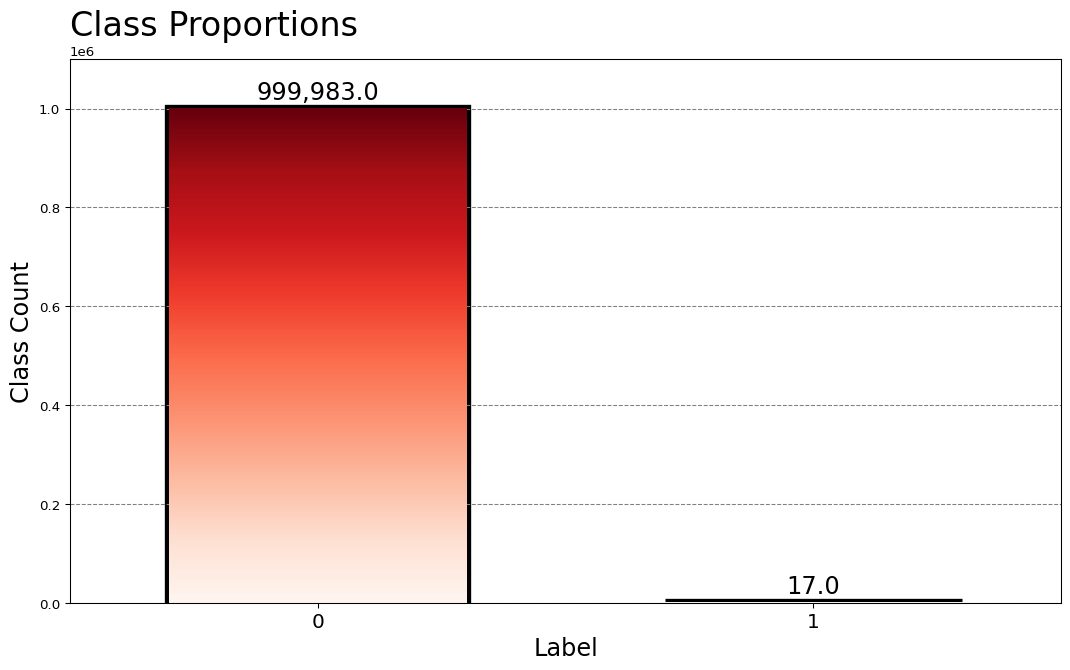

In [433]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
ax = plt.gca()
bar1 = ax.bar(x = risk_ratios.index, height = risk_ratios, width=0.6, edgecolor='k', linewidth=7)
ax.bar_label(bar1, labels=[f'{e:,.1f}' for e in risk_ratios], padding=3, color='black', fontsize=18)
gradientbars(bar1, risk_ratios.values, 'Reds')


plt.ylabel('Class Count', fontsize=18)
#plt.yticks([i*10 for i in range(1, 7)], labels=[f'{i*10}' for i in range(1, 7)], fontsize=15)
plt.title('Class Proportions', fontsize=25, y=1.03, loc='left')
plt.xlabel('Label', fontsize=18)
plt.xticks([0, 1], fontsize=15)
plt.axis([-0.5, 1.5, 0, 1100000])
ax.grid(which='major', axis='y', linestyle='--', color='gray', zorder=0)
plt.show()

In [186]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT',
            'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 
            'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE']
cat_ohe_cols = ['PEP_FL', 'OCPTN_RISK']
cat_non_ohe_cols = []
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA', 'OCPTN_NM', 'BAD_ACTOR']
data = nodes[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]
data_0 = data[data['BAD_ACTOR'] == 0].sample(frac=0.01)
data_1 = data[data['BAD_ACTOR'] == 1]
data = pd.concat([data_0, data_1], axis=0).sample(frac=1)

imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

fold_dict_list = []
for i in tqdm.tqdm(range(30)):
    fold_dict_list.append(get_data(data.sample(frac=1),
                 num_cols, 
                 cat_ohe_cols, 
                 cat_non_ohe_cols, 
                 n_folds=3))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.22it/s]


### Threshold tuning

In [441]:
tot_results = []
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    results = []
    for fold_dict in tqdm.tqdm(fold_dict_list):

        model = SuperModel(n_estimators=200, sample_size_0=100, sample_size_1=100, k_neighbors=4, smote=True, threshold=thresh)
        results.append(run_model(model, fold_dict))
    tot_results.append(sum(results)/10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:56<00:00, 11.66s/it]


In [ ]:
bad_actor_recall = [tot_results[i].loc['bad actor', 'val'] for i in range(len(tot_results))]
not_bad_actor_recall = [tot_results[i].loc['not bad actor', 'val'] for i in range(len(tot_results))]

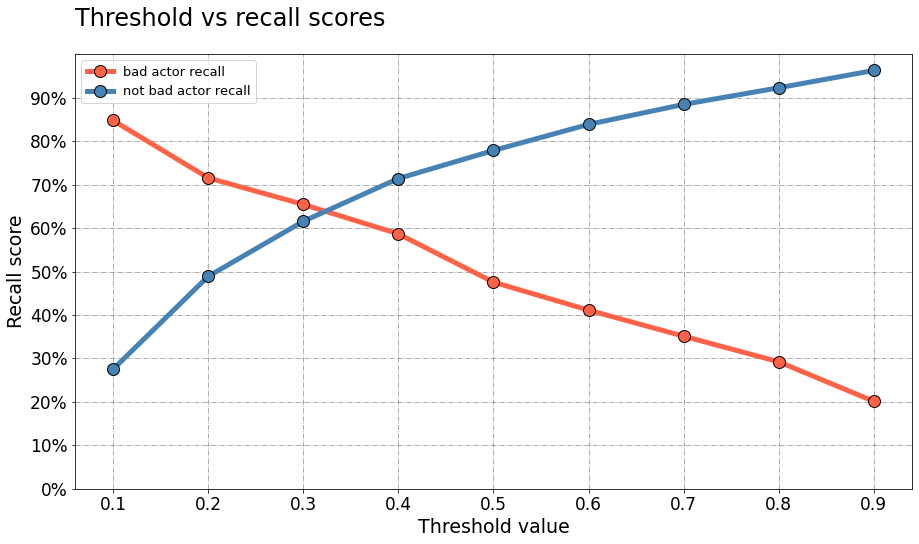

In [462]:
plt.figure(figsize=(15, 8))

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], bad_actor_recall, '-o', linewidth=5, markersize=12, mec='k', color='tomato', label='bad actor recall')
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], not_bad_actor_recall, '-o', linewidth=5, markersize=12, mec='k', color='steelblue', label='not bad actor recall')
plt.title('Threshold vs recall scores', fontsize=24, loc='Left', y=1.05)

plt.ylabel('Recall score', fontsize=19)
plt.yticks(ticks=[0.1*i for i in range(10)], labels=[f'{i*10}%' for i in range(10)], fontsize=17)

plt.xlabel('Threshold value', fontsize=19)
plt.xticks(fontsize=17)


plt.legend(fontsize=13)
plt.grid(alpha=0.4, linestyle='-.', color='k')
plt.show()

## Modelling

In [ ]:
results_dict = dict()

### SuperLogisticRegression

In [373]:
results = []
for fold_dict in tqdm.tqdm(fold_dict_list):
    
    model = SuperModel(n_estimators=200, sample_size_0=100, sample_size_1=100, k_neighbors=4, smote=True)
    results.append(run_model(model, fold_dict))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:55<00:00, 11.83s/it]


In [374]:
results_dict['SuperLogReg'] = sum(results)/30

In [375]:
results_dict['SuperLogReg']

,train,val
not bad actor,0.786130,0.784491
bad actor,0.801768,0.521111


In [423]:
nodes = pd.read_csv('nodes_data_graph.csv')

### LogisticRegression

In [376]:
results = []
for fold_dict in tqdm.tqdm(fold_dict_list):
    classes = np.unique(fold_dict['fold_1'][2].to_numpy())
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_dict['fold_1'][2])
    class_weights = dict(zip(classes, weights))

    model = LogisticRegression(class_weight=class_weights)
    results.append(run_model(model, fold_dict))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.22it/s]


In [377]:
results_dict['LogReg'] = sum(results)/30

In [378]:
results_dict['LogReg']

,train,val
not bad actor,0.822316,0.821345
bad actor,0.847980,0.489259


### SuperLGBM

In [383]:
results = []
i = 0
for fold_dict in tqdm.tqdm(fold_dict_list):

    model = SuperModel(base_model=LGBMClassifier(max_depth=2), n_estimators=100, sample_size_0=100,
                       sample_size_1=100, k_neighbors=5, smote=True, kwargs={'early_stopping_rounds':100, 'verbose':0})
    results.append(run_model(model, fold_dict))


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [06:37<00:00, 13.25s/it]


In [384]:
results_dict['SuperLGBM'] = sum(results)/30

In [385]:
results_dict['SuperLGBM']

,train,val
not bad actor,0.913553,0.912567
bad actor,0.955387,0.408889


### LGBM

In [338]:
results = []
for fold_dict in tqdm.tqdm(fold_dict_list):
    classes = np.unique(fold_dict['fold_1'][2].to_numpy())
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_dict['fold_1'][2])
    class_weights = dict(zip(classes, weights))

    kwargs = {'early_stopping_rounds':100, 
              'verbose':0}
    model = LGBMClassifier(max_depth=2, class_weight=class_weights)
    results.append(run_model(model, fold_dict, kwargs=kwargs))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]


In [343]:
results_dict['LGBM'] = sum(results)/30

In [344]:
results_dict['LGBM']

,train,val
not bad actor,0.983937,0.982980
bad actor,1.000000,0.208889


### SuperRandomForest

In [417]:
results = []
for fold_dict in tqdm.tqdm(fold_dict_list):

    model = SuperModel(base_model=RandomForestClassifier(max_depth=2), n_estimators=100, sample_size_0=100,
                       sample_size_1=100, k_neighbors=5, smote=True)
    results.append(run_model(model, fold_dict))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [07:38<00:00, 15.29s/it]


In [412]:
results_dict['SuperRandomForest'] = sum(results)/30

In [413]:
results_dict['SuperRandomForest']

,train,val
not bad actor,0.831338,0.83054
bad actor,0.867256,0.55963


### RandomForest

In [414]:
results = []
for fold_dict in tqdm.tqdm(fold_dict_list):
    classes = np.unique(fold_dict['fold_1'][2].to_numpy())
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_dict['fold_1'][2])
    class_weights = dict(zip(classes, weights))

    kwargs = {'early_stopping_rounds':100, 
          'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
    model = RandomForestClassifier(n_estimators=200, max_depth=2, class_weight=class_weights)
    results.append(run_model(model, fold_dict))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:52<00:00,  1.76s/it]


In [415]:
results_dict['RandomForest'] = sum(results)/30

In [416]:
results_dict['RandomForest']

,train,val
not bad actor,0.958464,0.958144
bad actor,0.820875,0.308148


In [419]:
def get_results_list(row, results):
    res = []
    for model, result in results.items():
        for col in ['train', 'val']:
                res.append([model, result.loc[row, col], col])
    return pd.DataFrame(res, columns=['model', 'score', 'split'])

In [420]:
not_bad_actor = get_results_list('not bad actor', results_dict)
bad_actor = get_results_list('bad actor', results_dict)

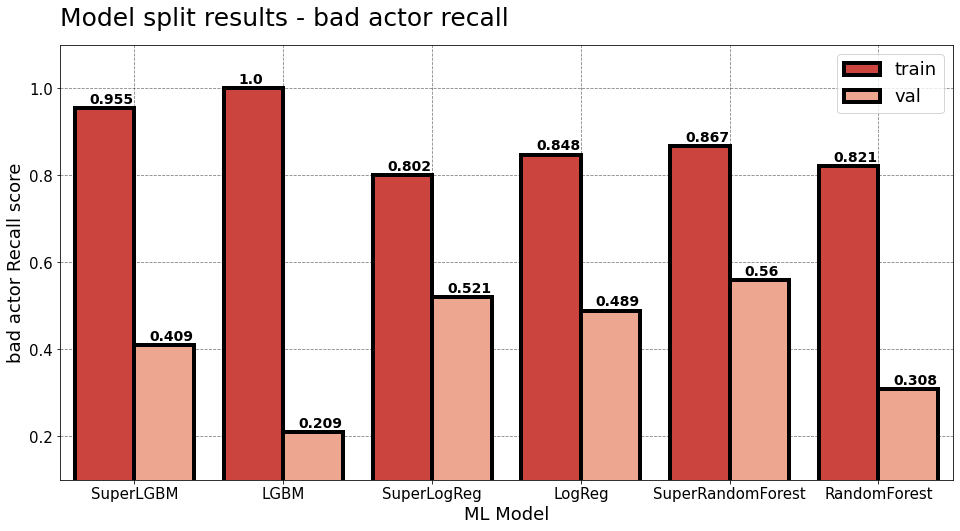

In [422]:
plt.figure(figsize=(16, 8))

sns.barplot(x='model', y='score', hue='split', data=bad_actor, edgecolor='k', linewidth=4, zorder=4, palette='Reds_r')
plt.xlabel('ML Model', fontsize=18)
plt.ylabel('bad actor Recall score', fontsize=18)
plt.title('Model split results - bad actor recall', fontsize=25, loc='left', y=1.03)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)#, ticks=[i*10 for i in range(0, 10)], labels=[f'{i*10}%' for i in range(0, 10)] )
for i, label in enumerate(['SuperLGBM', 'LGBM', 'SuperLogReg', 'LogReg', 'SuperRandomForest', 'RandomForest']):
    temp2 = bad_actor[bad_actor['model'] == label]
    k = 0
    for j, val in enumerate(temp2['score']):
        plt.text(i-0.3+k*2, val+0.01, f'{np.round(val, 3)}', weight='bold', fontsize=14, color='k')
        k += 0.2

plt.grid(alpha=0.5, color='k', linestyle='--')
plt.legend(fontsize=18)
plt.axis([-0.5, 5.5, 0.1, 1.1])
plt.show()

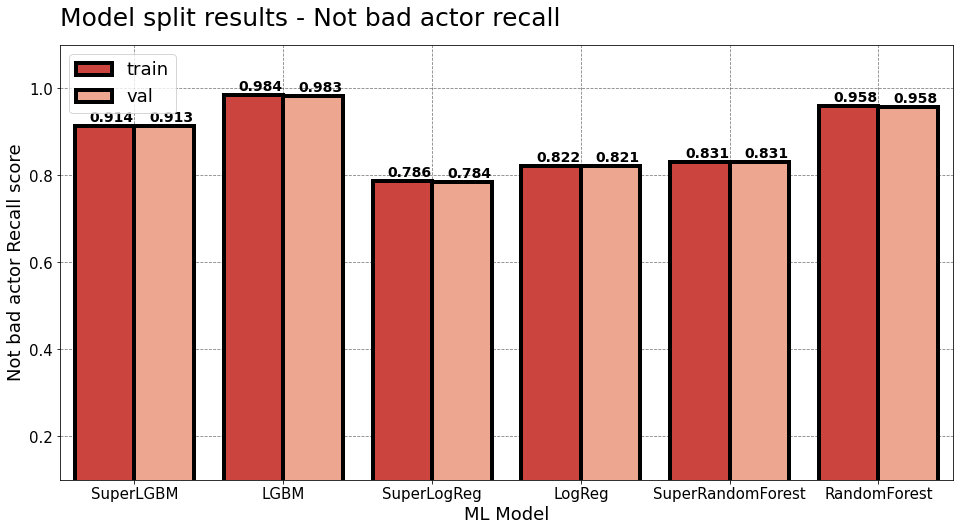

In [464]:
plt.figure(figsize=(16, 8))

sns.barplot(x='model', y='score', hue='split', data=not_bad_actor, edgecolor='k', linewidth=4, zorder=4, palette='Reds_r')
plt.xlabel('ML Model', fontsize=18)
plt.ylabel('Not bad actor Recall score', fontsize=18)
plt.title('Model split results - Not bad actor recall', fontsize=25, loc='left', y=1.03)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)#, ticks=[i*10 for i in range(0, 10)], labels=[f'{i*10}%' for i in range(0, 10)] )
for i, label in enumerate(['SuperLGBM', 'LGBM', 'SuperLogReg', 'LogReg', 'SuperRandomForest', 'RandomForest']):
    temp2 = not_bad_actor[not_bad_actor['model'] == label]
    k = 0
    for j, val in enumerate(temp2['score']):
        plt.text(i-0.3+k*2, val+0.01, f'{np.round(val, 3)}', weight='bold', fontsize=14, color='k')
        k += 0.2

plt.grid(alpha=0.5, color='k', linestyle='--')
plt.legend(fontsize=18)
plt.axis([-0.5, 5.5, 0.1, 1.1])
plt.show()